# US Income Prediction

## Introduction
In this project, we will be using a dataset containing hypothetical census information.

By using this census data with a **Random Forest**, we will try to predict whether or not a person makes more than $50,000. So basically our prediction will be binary.

## Import Required Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.metrics import accuracy_score, classification_report
import itertools

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
# Function to calculate weighted Point-Biserial Correlation and p-value
def weighted_point_biserial(x, y, weights):
    """
    Calculates the weighted Point-Biserial Correlation between a binary variable `y` (0, 1)
    and a continuous variable `x`, considering the weights for each observation.
    Returns both the correlation coefficient and the p-value.
    """
    # Ensure that `y` is binary
    unique_vals = np.unique(y)
    if not set(unique_vals).issubset({0, 1}):
        raise ValueError("`y` should be binary (only 0 and 1 allowed).")

    # Calculate weighted mean and standard deviation of `x`
    mean_x = np.average(x, weights=weights)
    std_x = np.sqrt(np.average((x - mean_x) ** 2, weights=weights))

    # Calculate weighted means for the groups where `y` is 0 and 1
    mean_x_0 = np.average(x[y == 0], weights=weights[y == 0])
    mean_x_1 = np.average(x[y == 1], weights=weights[y == 1])

    # Calculate the proportion of `y` being 1 (p) and 0 (q)
    p = np.average(y, weights=weights)
    q = 1 - p

    # Calculate Point-Biserial Correlation
    r_pb = (mean_x_1 - mean_x_0) / std_x * np.sqrt(p * q)

    # Degrees of freedom
    n = len(x)
    df = n - 2  # Degrees of freedom for Point-Biserial Correlation

    # Calculate the t-statistic
    t_stat = r_pb * np.sqrt(df / (1 - r_pb**2))

    # Calculate the p-value from the t-statistic
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))  # Two-tailed test

    return r_pb, p_value

In [3]:
# Function to calculate weighted Chi-square and Cramér's V
def weighted_chi2_and_cramers_v(df, col1, col2, weight_col):
    """
    Calculates the weighted chi-square statistic and Cramér's V
    from a contingency table that uses the weights in `weight_col`.
    """
    if col1==col2:
        return 0, 0, 1
    
    # Create a weighted contingency table
    weighted_contingency_table = pd.crosstab(
        df[col1],  # First categorical column
        df[col2],  # Second categorical column
        values=df[weight_col],  # Frequency or weight column
        aggfunc=np.sum  # Sum the weights
    )
    weighted_contingency_table.fillna(0, inplace=True)  # Replace NaN with zero
    # Calculate the chi-square statistic from the weighted contingency table
    chi2, p_value, dof, expected = stats.chi2_contingency(weighted_contingency_table)

    # Calculate Cramér's V
    n = df[weight_col].sum()  # Total weighted count
    min_dim = min(weighted_contingency_table.shape)  # Minimum dimension in the contingency table
    cramers_v_value = np.sqrt(chi2 / (n * (min_dim - 1)))

    return chi2, p_value, cramers_v_value  # Return chi-square, p-value, and Cramér's V

In [4]:
# Function to create Cramér's V matrix
def cramers_v_matrix(df, weight, categorical_columns):
    # Get all combinations of categorical columns
    combinations = list(itertools.product(categorical_columns, repeat=2))
    #print(combinations)

    # Create a DataFrame to store Cramér's V values
    results = pd.DataFrame(index=categorical_columns, columns=categorical_columns, data=np.nan)
    #print(results)

    for col1, col2 in combinations:
        chi2, p_value, cramers_v = weighted_chi2_and_cramers_v(df, col1, col2, weight)
        #print(f"{col1}, {col2}, {cramers_v}")
        results.loc[col1, col2] = cramers_v
        results.loc[col2, col1] = cramers_v
    
    return results

## Load and Inspect Data

In [5]:
df = pd.read_csv("income.csv")
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Feature Descriptions
- `age`: An integer representing the age of a person.
- `workclass`: A categorical variable indicating the type of employment or work category.
- `fnlwgt`: Stands for "final weight," a variable used to indicate the relative importance of each observation. It's derived from census data to account for sampling and ensure the dataset represents the population.
- `education`: A categorical variable representing the highest level of education attained.
- `marital-status`: A categorical variable representing a person's marital status.
- `occupation`: A categorical variable indicating a person's occupation or job type.
- `relationship`: A categorical variable describing a person's relationship to others in the household.
- `race`: A categorical variable indicating a person's racial identity.
- `sex`: A categorical variable indicating the person's gender.
- `capital-gain`: An integer representing capital gains from investments or other financial activities.
- `capital-loss`: An integer representing capital losses from investments or other financial activities.
- `hours-per-week`: An integer indicating the number of hours worked per week.
- `native-country`: A categorical variable indicating the person's country of origin or citizenship.
- `income`: A categorical variable representing a person's income level, typically with values like '<=50K' and '>50K'.

In [6]:
# Check for NULLs
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

- There are no NULLs here so won't need to do deal with Missing Values

In [7]:
# Summarize Data
df.describe(include = "all")

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
count,32561.000000,32561,3.256100e+04,32561,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [8]:
df["income>50k"] = df['income'].apply(lambda x: 0 if x=="<=50K" else 1)

In [9]:
total_population = sum(df['fnlwgt'])
print(f"Total Population in the data set is: {total_population}")

Total Population in the data set is: 6179373392


### Observations
1. US Workforce's Age ranges from 17 to 90
2. There are 9 Work Classes
3. There are 16 Educational Degrees
4. There are 7 Types of Marital Status
5. There are 15 Occupations
6. There are 6 relationship (These relationship might be correlated with Marital Status)
7. There are 5 Races
8. Very few people are making capital-gain and capital-loss
9. Avg capital-gain is higher than capital-loss
10. Total population in the data set is 6.18 Billion (so we confirm that this is hypothetical data)

## EDA

### Age

In [10]:
pivot_df = df.pivot_table(index='age', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given Age"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df[["age", "% Share of Total Population", "% Population with income>50k for given Age"]]

index,age,% Share of Total Population,% Population with income>50k for given Age
0,17,1.19,0.00
1,18,1.72,0.00
2,19,2.36,0.36
3,20,2.42,0.00
4,21,2.33,0.76
5,22,2.50,1.80
6,23,2.93,1.08
7,24,2.65,4.13
8,25,2.76,6.22
9,26,2.45,7.78


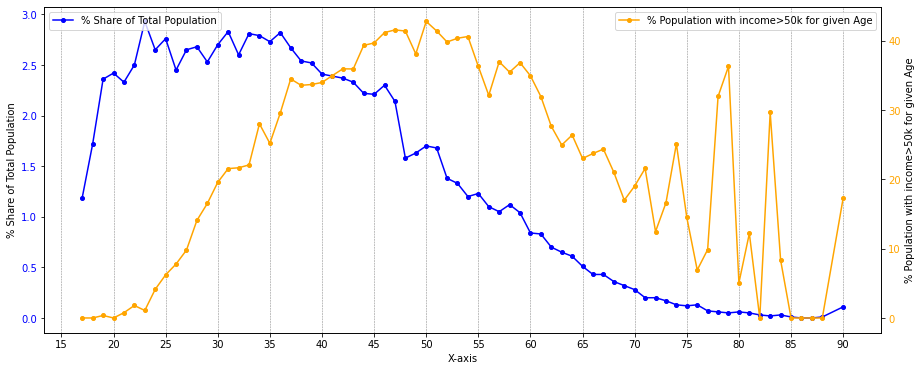

In [11]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.plot(pivot_df["age"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", marker = "o", markersize=4)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.set_xticks(range(0, 100, 5))  # Change to specific tick values
ax1.grid(True, axis='x', color='gray', linestyle='--', linewidth=0.5)  # Enable vertical grid lines
ax1.legend(loc="upper left")

# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.plot(pivot_df["age"], pivot_df["% Population with income>50k for given Age"], color = 'orange', label = "% Population with income>50k for given Age", marker = "o", markersize=4)
ax2.set_ylabel("% Population with income>50k for given Age")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

- At lower age fewer people have income >50k
- At the age above 70 the % Population with income>50k is very fluctuating and also the % Share of Population after this age is very low
- Here we see that people with <=50K income decrease until the age of 50 but then starts to increase again

In [12]:
# Calculate the weighted Point-Biserial Correlation and p-value
weighted_pb_corr, pb_p_value = weighted_point_biserial(df['age'], df['income>50k'], df['fnlwgt'])

print("Weighted Point-Biserial Correlation:", weighted_pb_corr.round(3))
print("p-value:", pb_p_value.round(3))

Weighted Point-Biserial Correlation: 0.243
p-value: 0.0


In [13]:
# Define the binning intervals for age
age_bins = range(16, 96, 5)  # Create bins from 0 to 100 with intervals of 5
age_labels = [f"{i}-{i+4}" for i in age_bins[:-1]]  # Create bin labels

# Bin the 'age' column using 'cut'
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Pivot for age_group
pivot_df = df.pivot_table(index='age_group', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given Age"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df[['% Share of Total Population', '% Population with income>50k for given Age']] = pivot_df[['% Share of Total Population','% Population with income>50k for given Age']].fillna(value=0)
pivot_df[["age_group", "% Share of Total Population", "% Population with income>50k for given Age"]]

index,age_group,% Share of Total Population,% Population with income>50k for given Age
0,16-20,7.69,0.11
1,21-25,13.18,2.85
2,26-30,13.02,13.63
3,31-35,13.75,23.70
4,36-40,12.97,32.98
5,41-45,11.52,37.09
6,46-50,9.34,41.04
7,51-55,6.83,39.80
8,56-60,5.14,35.23
9,61-65,3.29,27.25


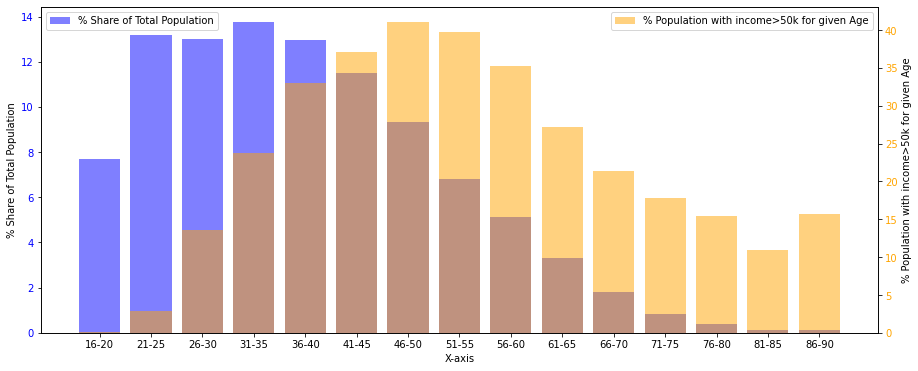

In [14]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.bar(pivot_df["age_group"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", alpha = 0.5)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.legend(loc="upper left")

# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.bar(pivot_df["age_group"], pivot_df["% Population with income>50k for given Age"], color = 'orange', label = "% Population with income>50k for given Age", alpha = 0.5)
ax2.set_ylabel("% Population with income>50k for given Age")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

In [15]:
# Calculate the weighted Chi-square and Cramér's V
chi2, p_value, cramers_v = weighted_chi2_and_cramers_v(df, 'age_group', 'income', 'fnlwgt')

print("Cramér's V:", cramers_v.round(3))
print("p-value:", p_value.round(3))

Cramér's V: 0.331
p-value: 0.0


### WorkClass

In [16]:
pivot_df = df.pivot_table(index='workclass', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given workclass"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df[["workclass", "% Share of Total Population", "% Population with income>50k for given workclass"]]

index,workclass,% Share of Total Population,% Population with income>50k for given workclass
0,?,5.60,10.13
1,Federal-gov,2.88,39.10
2,Local-gov,6.39,30.19
3,Never-worked,0.03,0.00
4,Private,70.80,21.45
5,Self-emp-inc,3.18,57.98
6,Self-emp-not-inc,7.22,29.69
7,State-gov,3.87,27.48
8,Without-pay,0.04,0.00


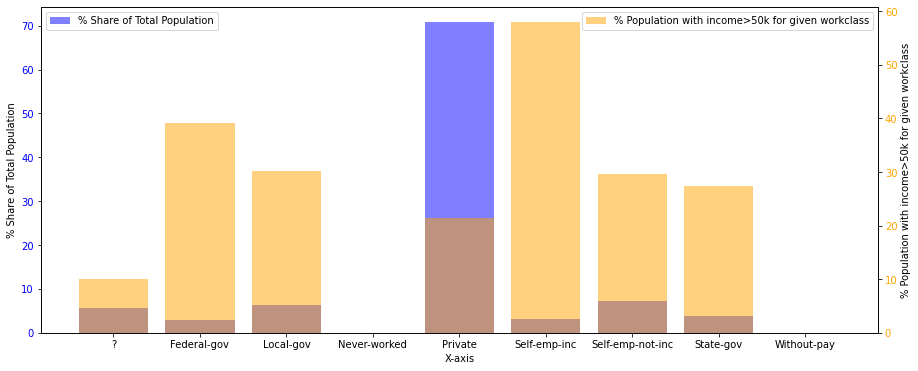

In [17]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.bar(pivot_df["workclass"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", alpha = 0.5)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.legend(loc="upper left")

# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.bar(pivot_df["workclass"], pivot_df["% Population with income>50k for given workclass"], color = 'orange', label = "% Population with income>50k for given workclass", alpha = 0.5)
ax2.set_ylabel("% Population with income>50k for given workclass")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

- Private Sector contributes to Highest workforce population (70.80%)
- Incorporated Self Employed has Highest % Population with income>50k (57.98%)
- Never-worked and Withpay-pay has 0% of Population with income>50k, which make sense as they have no earning

In [18]:
# Calculate the weighted Chi-square and Cramér's V
chi2, p_value, cramers_v = weighted_chi2_and_cramers_v(df, 'workclass', 'income', 'fnlwgt')

print("Cramér's V:", cramers_v.round(3))
print("p-value:", p_value.round(3))

Cramér's V: 0.188
p-value: 0.0


### Education

In [19]:
pivot_df = df.pivot_table(index='education', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given education"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df[["education", "% Share of Total Population", "% Population with income>50k for given education"]]

index,education,% Share of Total Population,% Population with income>50k for given education
0,10th,2.97,6.68
1,11th,3.71,4.41
2,12th,1.40,8.06
3,1st-4th,0.65,3.43
4,5th-6th,1.25,3.48
5,7th-8th,1.97,5.77
6,9th,1.68,4.31
7,Assoc-acdm,3.34,24.58
8,Assoc-voc,4.07,26.17
9,Bachelors,16.30,41.89


C:\Users\soura\AppData\Local\Temp\ipykernel_17636\878158600.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(list(pivot_df["education"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


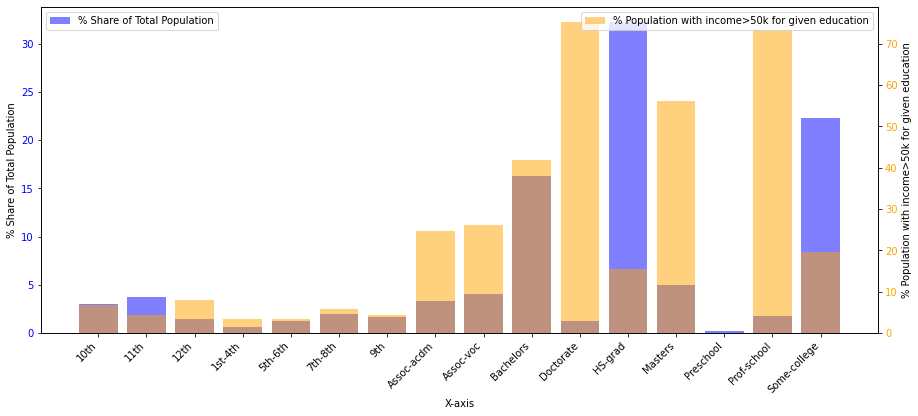

In [20]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.bar(pivot_df["education"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", alpha = 0.5)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.legend(loc="upper left")
ax1.set_xticklabels(list(pivot_df["education"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.bar(pivot_df["education"], pivot_df["% Population with income>50k for given education"], color = 'orange', label = "% Population with income>50k for given education", alpha = 0.5)
ax2.set_ylabel("% Population with income>50k for given education")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

- HS-grad and Some-college (who didn't complete the degree) make up for 54.48% of population while less than 20% of them are earning >50k
- Doctorate and Prof-schools has highest percentage of people with income>50k

In [21]:
# Calculate the weighted Chi-square and Cramér's V
chi2, p_value, cramers_v = weighted_chi2_and_cramers_v(df, 'education', 'income', 'fnlwgt')

print("Cramér's V:", cramers_v.round(3))
print("p-value:", p_value.round(3))

Cramér's V: 0.375
p-value: 0.0


### Marital Status

In [22]:
pivot_df = df.pivot_table(index='marital-status', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given marital-status"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df[["marital-status", "% Share of Total Population", "% Population with income>50k for given marital-status"]]

index,marital-status,% Share of Total Population,% Population with income>50k for given marital-status
0,Divorced,13.36,10.40
1,Married-AF-spouse,0.07,38.45
2,Married-civ-spouse,45.26,44.96
3,Married-spouse-absent,1.31,6.71
4,Never-married,33.78,4.62
5,Separated,3.42,6.57
6,Widowed,2.80,7.84


C:\Users\soura\AppData\Local\Temp\ipykernel_17636\421590223.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(list(pivot_df["marital-status"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


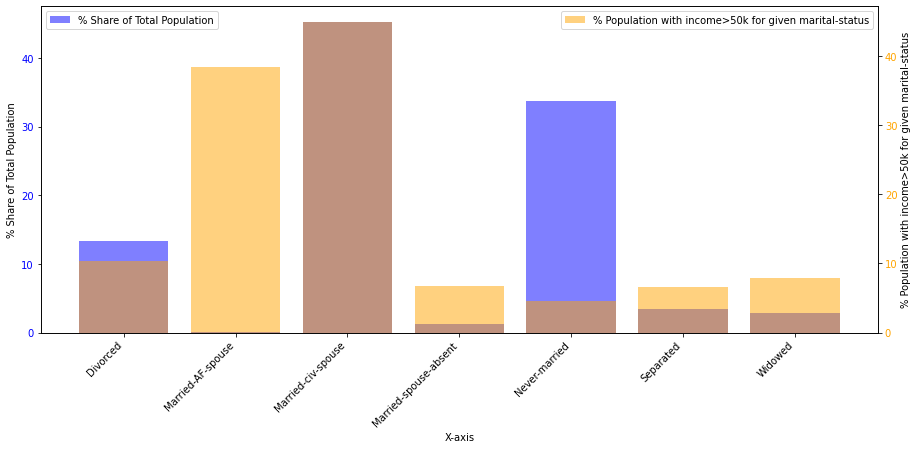

In [23]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.bar(pivot_df["marital-status"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", alpha = 0.5)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.legend(loc="upper left")
ax1.set_xticklabels(list(pivot_df["marital-status"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.bar(pivot_df["marital-status"], pivot_df["% Population with income>50k for given marital-status"], color = 'orange', label = "% Population with income>50k for given marital-status", alpha = 0.5)
ax2.set_ylabel("% Population with income>50k for given marital-status")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

- Married-civ-spouse have the highest percentage of people with income>50k as well as highest percentage of total population
- In the current workforce, there are 33.78% of people who aren't married yet

In [24]:
# Calculate the weighted Chi-square and Cramér's V
chi2, p_value, cramers_v = weighted_chi2_and_cramers_v(df, 'marital-status', 'income', 'fnlwgt')

print("Cramér's V:", cramers_v.round(3))
print("p-value:", p_value.round(3))

Cramér's V: 0.453
p-value: 0.0


### Relationship

In [25]:
pivot_df = df.pivot_table(index='relationship', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given relationship"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df[["relationship", "% Share of Total Population", "% Population with income>50k for given relationship"]]

index,relationship,% Share of Total Population,% Population with income>50k for given relationship
0,Husband,39.94,45.14
1,Not-in-family,25.69,10.34
2,Other-relative,3.26,3.15
3,Own-child,15.84,1.26
4,Unmarried,10.66,6.19
5,Wife,4.61,47.87


C:\Users\soura\AppData\Local\Temp\ipykernel_17636\1195450779.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(list(pivot_df["relationship"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


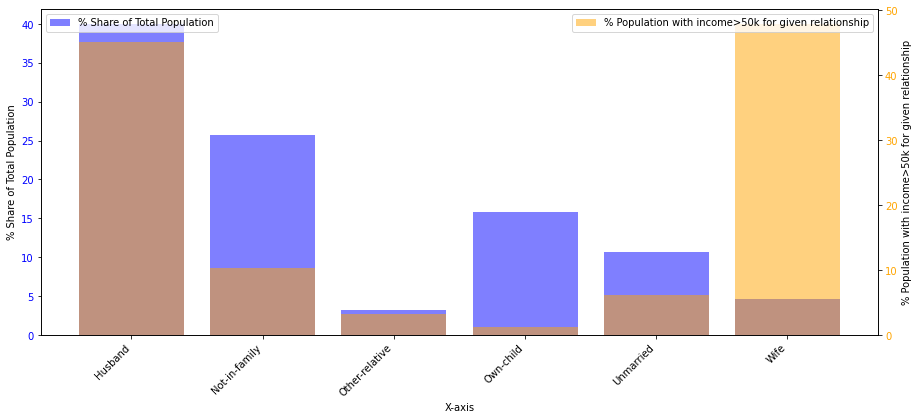

In [26]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.bar(pivot_df["relationship"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", alpha = 0.5)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.legend(loc="upper left")
ax1.set_xticklabels(list(pivot_df["relationship"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.bar(pivot_df["relationship"], pivot_df["% Population with income>50k for given relationship"], color = 'orange', label = "% Population with income>50k for given relationship", alpha = 0.5)
ax2.set_ylabel("% Population with income>50k for given relationship")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

- Husbands have highest % Share of Population in workforce
- Wifes have highest % Population with income>50k

In [27]:
# Calculate the weighted Chi-square and Cramér's V
chi2, p_value, cramers_v = weighted_chi2_and_cramers_v(df, 'relationship', 'income', 'fnlwgt')

print("Cramér's V:", cramers_v.round(3))
print("p-value:", p_value.round(3))

Cramér's V: 0.459
p-value: 0.0


### Occupation

In [28]:
pivot_df = df.pivot_table(index='occupation', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given occupation"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df[["occupation", "% Share of Total Population", "% Population with income>50k for given occupation"]]

index,occupation,% Share of Total Population,% Population with income>50k for given occupation
0,?,5.63,10.08
1,Adm-clerical,11.72,13.08
2,Armed-Forces,0.03,17.76
3,Craft-repair,12.74,22.86
4,Exec-managerial,12.13,48.28
5,Farming-fishing,2.74,9.15
6,Handlers-cleaners,4.53,5.80
7,Machine-op-inspct,6.32,12.03
8,Other-service,10.06,4.06
9,Priv-house-serv,0.48,0.33


C:\Users\soura\AppData\Local\Temp\ipykernel_17636\2261872121.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(list(pivot_df["occupation"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


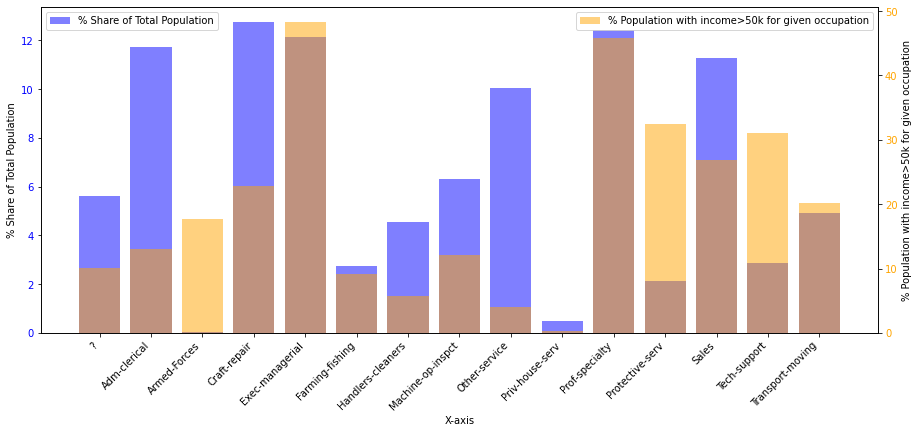

In [29]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.bar(pivot_df["occupation"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", alpha = 0.5)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.legend(loc="upper left")
ax1.set_xticklabels(list(pivot_df["occupation"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.bar(pivot_df["occupation"], pivot_df["% Population with income>50k for given occupation"], color = 'orange', label = "% Population with income>50k for given occupation", alpha = 0.5)
ax2.set_ylabel("% Population with income>50k for given occupation")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

- Craft-repair and Prof-speciality have almost same % Share of Population but % Population in respective fields with income>50k is two times in Prof-speciality then in Craft-repair

In [30]:
# Calculate the weighted Chi-square and Cramér's V
chi2, p_value, cramers_v = weighted_chi2_and_cramers_v(df, 'occupation', 'income', 'fnlwgt')

print("Cramér's V:", cramers_v.round(3))
print("p-value:", p_value.round(3))

Cramér's V: 0.358
p-value: 0.0


### Race

In [31]:
pivot_df = df.pivot_table(index='race', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given race"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df[["race", "% Share of Total Population", "% Population with income>50k for given race"]]

index,race,% Share of Total Population,% Population with income>50k for given race
0,Amer-Indian-Eskimo,0.61,12.44
1,Asian-Pac-Islander,2.69,27.62
2,Black,11.53,12.83
3,Other,0.86,9.07
4,White,84.31,25.48


C:\Users\soura\AppData\Local\Temp\ipykernel_17636\3465002193.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(list(pivot_df["race"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


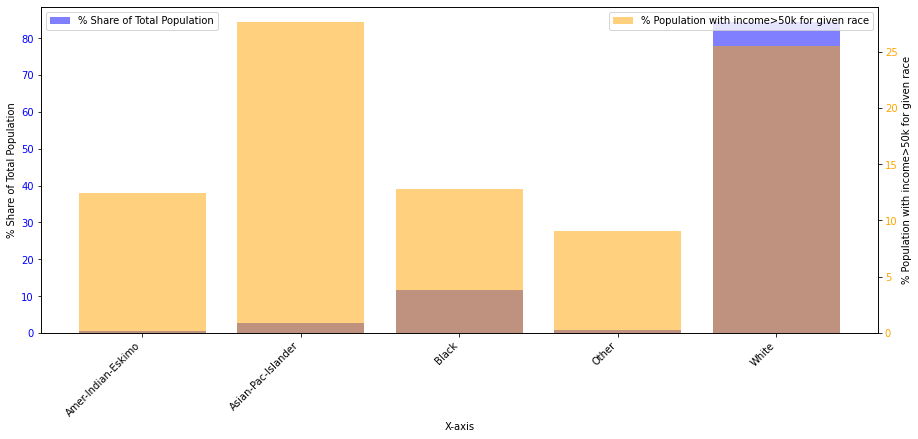

In [32]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.bar(pivot_df["race"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", alpha = 0.5)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.legend(loc="upper left")
ax1.set_xticklabels(list(pivot_df["race"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.bar(pivot_df["race"], pivot_df["% Population with income>50k for given race"], color = 'orange', label = "% Population with income>50k for given race", alpha = 0.5)
ax2.set_ylabel("% Population with income>50k for given race")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

- White has the highest share in Total Population (84.31%)
- % Population with income>50k is second highest in White race (25.48%) and First highest for Asian-pac-islander (27.62%)

In [33]:
# Calculate the weighted Chi-square and Cramér's V
chi2, p_value, cramers_v = weighted_chi2_and_cramers_v(df, 'race', 'income', 'fnlwgt')

print("Cramér's V:", cramers_v.round(3))
print("p-value:", p_value.round(3))

Cramér's V: 0.103
p-value: 0.0


### Sex

In [34]:
pivot_df = df.pivot_table(index='sex', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given sex"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df[["sex", "% Share of Total Population", "% Population with income>50k for given sex"]]

index,sex,% Share of Total Population,% Population with income>50k for given sex
0,Female,32.38,10.82
1,Male,67.62,30.10


C:\Users\soura\AppData\Local\Temp\ipykernel_17636\2800249900.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(list(pivot_df["sex"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


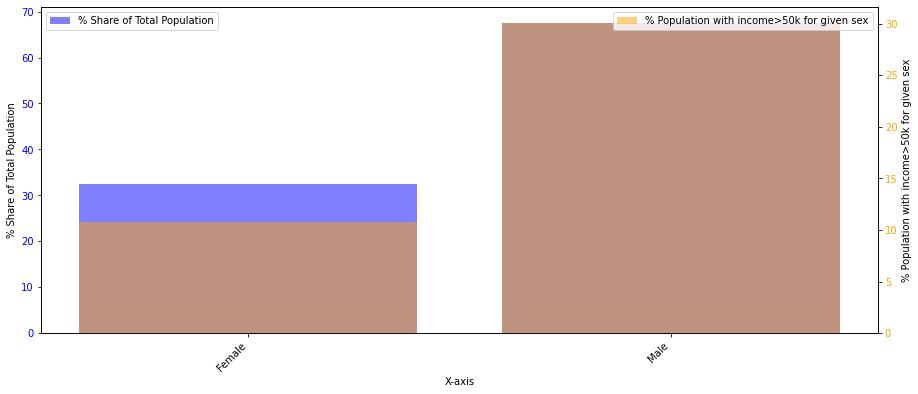

In [35]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.bar(pivot_df["sex"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", alpha = 0.5)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.legend(loc="upper left")
ax1.set_xticklabels(list(pivot_df["sex"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.bar(pivot_df["sex"], pivot_df["% Population with income>50k for given sex"], color = 'orange', label = "% Population with income>50k for given sex", alpha = 0.5)
ax2.set_ylabel("% Population with income>50k for given sex")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

- Males make up for 67.62% of Total Population in Workforce
- Male population has 30.10% of people with income>50k

In [36]:
# Calculate the weighted Chi-square and Cramér's V
chi2, p_value, cramers_v = weighted_chi2_and_cramers_v(df, 'sex', 'income', 'fnlwgt')

print("Cramér's V:", cramers_v.round(3))
print("p-value:", p_value.round(3))

Cramér's V: 0.212
p-value: 0.0


### Working Hours

In [37]:
pivot_df = df.pivot_table(index='hours-per-week', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given hours-per-week"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df[["hours-per-week", "% Share of Total Population", "% Population with income>50k for given hours-per-week"]]

index,hours-per-week,% Share of Total Population,% Population with income>50k for given hours-per-week
0,1,0.05,5.58
1,2,0.11,25.52
2,3,0.12,1.10
3,4,0.14,8.97
4,5,0.17,14.36
5,6,0.18,12.34
6,7,0.07,11.53
7,8,0.45,7.72
8,9,0.05,7.01
9,10,0.79,7.59


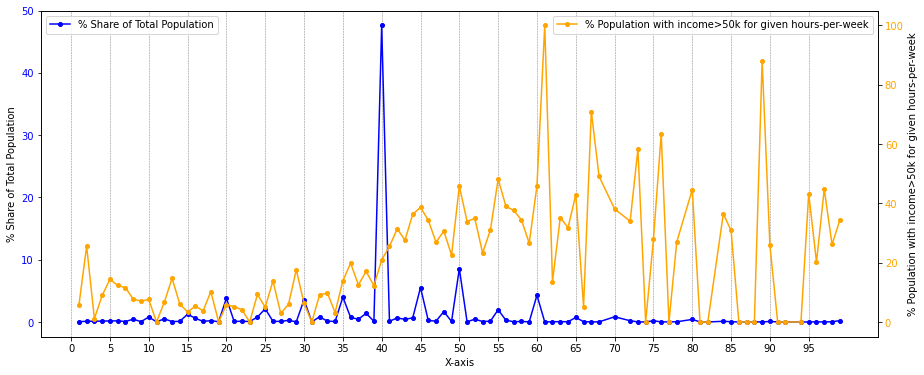

In [38]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.plot(pivot_df["hours-per-week"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", marker = "o", markersize=4)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.set_xticks(range(0, 100, 5))  # Change to specific tick values
ax1.grid(True, axis='x', color='gray', linestyle='--', linewidth=0.5)  # Enable vertical grid lines
ax1.legend(loc="upper left")

# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.plot(pivot_df["hours-per-week"], pivot_df["% Population with income>50k for given hours-per-week"], color = 'orange', label = "% Population with income>50k for given hours-per-week", marker = "o", markersize=4)
ax2.set_ylabel("% Population with income>50k for given hours-per-week")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

- Lesser % People have have income>50k for people who are working less than 40 hours compared to the people who are working more than 40 hours
- The Spike of % Share of Total population working for 40 hours accounts for 47.62%

In [39]:
# Calculate the weighted Point-Biserial Correlation and p-value
weighted_pb_corr, pb_p_value = weighted_point_biserial(df['hours-per-week'], df['income>50k'], df['fnlwgt'])

print("Weighted Point-Biserial Correlation:", weighted_pb_corr.round(3))
print("p-value:", pb_p_value.round(3))

Weighted Point-Biserial Correlation: 0.239
p-value: 0.0


In [40]:
# Define the binning intervals for hours-per-week
hours_per_week_bins = range(16, 96, 5)  # Create bins from 0 to 100 with intervals of 5
hours_per_week_labels = [f"{i}-{i+4}" for i in hours_per_week_bins[:-1]]  # Create bin labels

# Bin the 'hours-per-week' column using 'cut'
df['work_hour_group'] = pd.cut(df['hours-per-week'], bins=hours_per_week_bins, labels=hours_per_week_labels, right=False)

# Pivot for work_hour_group
pivot_df = df.pivot_table(index='work_hour_group', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given hours-per-week"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df[['% Share of Total Population', '% Population with income>50k for given hours-per-week']] = pivot_df[['% Share of Total Population','% Population with income>50k for given hours-per-week']].fillna(value=0)
pivot_df[["work_hour_group", "% Share of Total Population", "% Population with income>50k for given hours-per-week"]]

index,work_hour_group,% Share of Total Population,% Population with income>50k for given hours-per-week
0,16-20,4.75,5.85
1,21-25,3.17,5.92
2,26-30,4.03,6.44
3,31-35,5.05,12.76
4,36-40,50.28,20.71
5,41-45,7.37,36.99
6,46-50,10.70,42.78
7,51-55,2.64,44.24
8,56-60,4.72,45.20
9,61-65,0.86,40.74


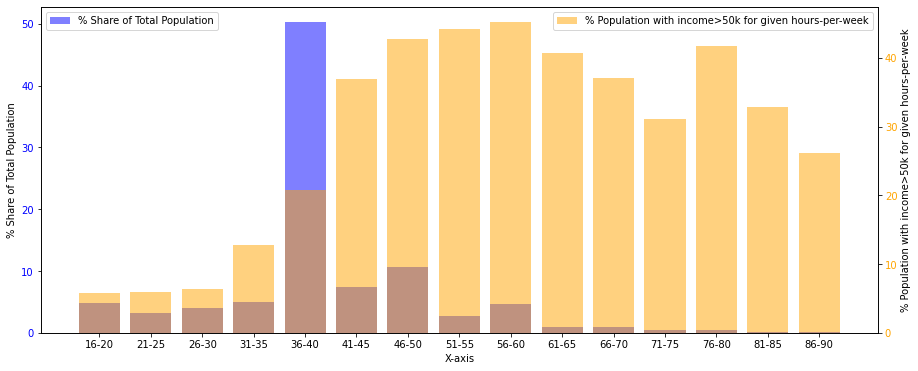

In [41]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.bar(pivot_df["work_hour_group"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", alpha = 0.5)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.legend(loc="upper left")

# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.bar(pivot_df["work_hour_group"], pivot_df["% Population with income>50k for given hours-per-week"], color = 'orange', label = "% Population with income>50k for given hours-per-week", alpha = 0.5)
ax2.set_ylabel("% Population with income>50k for given hours-per-week")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

In [42]:
# Calculate the weighted Chi-square and Cramér's V
chi2, p_value, cramers_v = weighted_chi2_and_cramers_v(df, 'work_hour_group', 'income', 'fnlwgt')

print("Cramér's V:", cramers_v.round(3))
print("p-value:", p_value.round(3))

Cramér's V: 0.273
p-value: 0.0


### Native Country

In [43]:
pivot_df = df.pivot_table(index='native-country', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given native-country"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df = pivot_df.sort_values(by = ["% Share of Total Population"], ascending = False)
pivot_df[["native-country", "% Share of Total Population", "% Population with income>50k for given native-country"]]

index,native-country,% Share of Total Population,% Population with income>50k for given native-country
39,United-States,88.31,24.63
26,Mexico,3.01,5.36
0,?,1.82,24.25
30,Philippines,0.53,33.04
8,El-Salvador,0.44,4.99
11,Germany,0.42,33.68
5,Cuba,0.38,27.03
33,Puerto-Rico,0.37,11.51
2,Canada,0.35,36.22
23,Jamaica,0.28,12.32


- Looking at this data we will create a new feature `is_us_native`
- US Natives makes up for 88.31% of Total Workforce Population

In [44]:
df["is_us_native"] = df["native-country"].apply(lambda x: "yes" if x=="United-States" else "no")

In [45]:
pivot_df = df.pivot_table(index='is_us_native', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given is_us_native"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df = pivot_df.sort_values(by = ["% Share of Total Population"], ascending = False)
pivot_df[["is_us_native", "% Share of Total Population", "% Population with income>50k for given is_us_native"]]

index,is_us_native,% Share of Total Population,% Population with income>50k for given is_us_native
1,yes,88.31,24.63
0,no,11.69,18.00


C:\Users\soura\AppData\Local\Temp\ipykernel_17636\2000147704.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(list(pivot_df["is_us_native"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


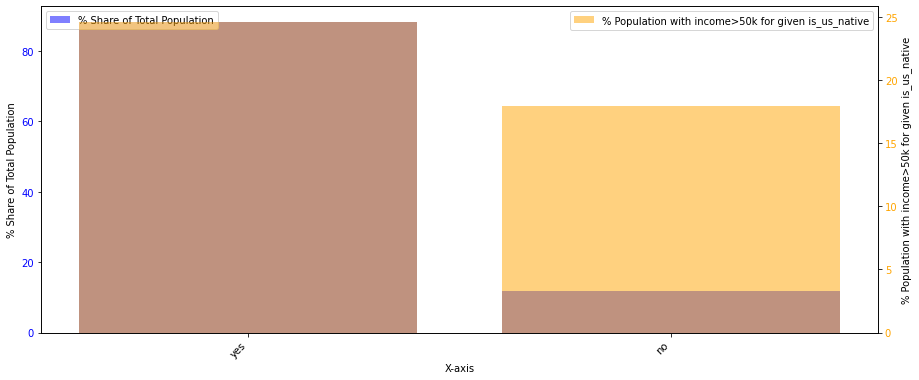

In [46]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.bar(pivot_df["is_us_native"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", alpha = 0.5)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.legend(loc="upper left")
ax1.set_xticklabels(list(pivot_df["is_us_native"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.bar(pivot_df["is_us_native"], pivot_df["% Population with income>50k for given is_us_native"], color = 'orange', label = "% Population with income>50k for given is_us_native", alpha = 0.5)
ax2.set_ylabel("% Population with income>50k for given is_us_native")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

In [47]:
# Calculate the weighted Chi-square and Cramér's V
chi2, p_value, cramers_v = weighted_chi2_and_cramers_v(df, 'is_us_native', 'income', 'fnlwgt')

print("Cramér's V:", cramers_v.round(3))
print("p-value:", p_value.round(3))

Cramér's V: 0.05
p-value: 0.0


### Capital Gains

In [48]:
# Define the binning intervals for capital-gain
df["capital_gain_group"] = df["capital-gain"].apply(lambda x: "0" if x==0 else
                                                               "1-5000" if x>=1 and x<=5000 else
                                                               "5001-10000" if x>=5001 and x<=10000 else
                                                               "10001+")

# Pivot for capital_gain_group
pivot_df = df.pivot_table(index='capital_gain_group', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given capital-gain"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df[['% Share of Total Population', '% Population with income>50k for given capital-gain']] = pivot_df[['% Share of Total Population','% Population with income>50k for given capital-gain']].fillna(value=0)
custom_order = ['0', '1-5000', '5001-10000', '10000+']  # Desired sorting order
order_map = {k: i for i, k in enumerate(custom_order)} # Create a mapping dictionary from the custom order
pivot_df = pivot_df.sort_values(by = ["capital_gain_group"], key=lambda x: x.map(order_map))
pivot_df[["capital_gain_group", "% Share of Total Population", "% Population with income>50k for given capital-gain"]]

index,capital_gain_group,% Share of Total Population,% Population with income>50k for given capital-gain
0,0,91.75,20.42
1,1-5000,3.25,17.23
3,5001-10000,2.63,84.73
2,10001+,2.38,97.94


C:\Users\soura\AppData\Local\Temp\ipykernel_17636\2392624412.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(list(pivot_df["capital_gain_group"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


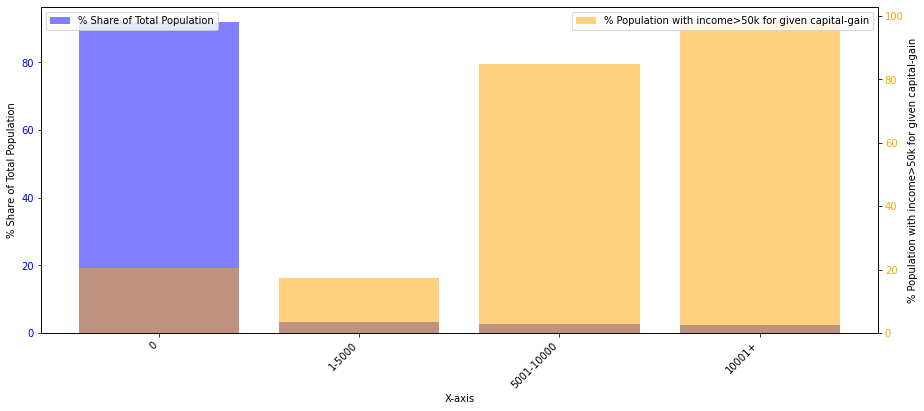

In [49]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.bar(pivot_df["capital_gain_group"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", alpha = 0.5)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.legend(loc="upper left")
ax1.set_xticklabels(list(pivot_df["capital_gain_group"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.bar(pivot_df["capital_gain_group"], pivot_df["% Population with income>50k for given capital-gain"], color = 'orange', label = "% Population with income>50k for given capital-gain", alpha = 0.5)
ax2.set_ylabel("% Population with income>50k for given capital-gain")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

In [50]:
# Calculate the weighted Chi-square and Cramér's V
chi2, p_value, cramers_v = weighted_chi2_and_cramers_v(df, 'capital_gain_group', 'income', 'fnlwgt')

print("Cramér's V:", cramers_v.round(3))
print("p-value:", p_value.round(3))

Cramér's V: 0.364
p-value: 0.0


## Capital Loss

In [51]:
# Define the binning intervals for capital-loss
df["capital_loss_group"] = df["capital-loss"].apply(lambda x: "0" if x==0 else
                                                               "1-1000" if x>=1 and x<=1000 else
                                                               "1001-2000" if x>=1001 and x<=2000 else
                                                               "2000+")

# Pivot for capital_loss_group
pivot_df = df.pivot_table(index='capital_loss_group', columns='income', values='fnlwgt', aggfunc='sum').reset_index().rename_axis('index', axis='columns')
pivot_df[["<=50K", ">50K"]] = pivot_df[["<=50K", ">50K"]].fillna(0)
pivot_df["% Share of Total Population"] = (100*(pivot_df["<=50K"]+pivot_df[">50K"])/total_population).round(2)
pivot_df["% Population with income>50k for given capital-loss"] = (100*pivot_df[">50K"]/(pivot_df["<=50K"]+pivot_df[">50K"])).round(2)
pivot_df[['% Share of Total Population', '% Population with income>50k for given capital-loss']] = pivot_df[['% Share of Total Population','% Population with income>50k for given capital-loss']].fillna(value=0)
custom_order = ['0', '1-1000', '1001-2000', '2000+']  # Desired sorting order
order_map = {k: i for i, k in enumerate(custom_order)} # Create a mapping dictionary from the custom order
pivot_df = pivot_df.sort_values(by = ["capital_loss_group"], key=lambda x: x.map(order_map))
pivot_df[["capital_loss_group", "% Share of Total Population", "% Population with income>50k for given capital-loss"]]

index,capital_loss_group,% Share of Total Population,% Population with income>50k for given capital-loss
0,0,95.44,22.53
1,1-1000,0.10,4.57
2,1001-2000,3.51,55.22
3,2000+,0.94,42.87


C:\Users\soura\AppData\Local\Temp\ipykernel_17636\489039274.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(list(pivot_df["capital_loss_group"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


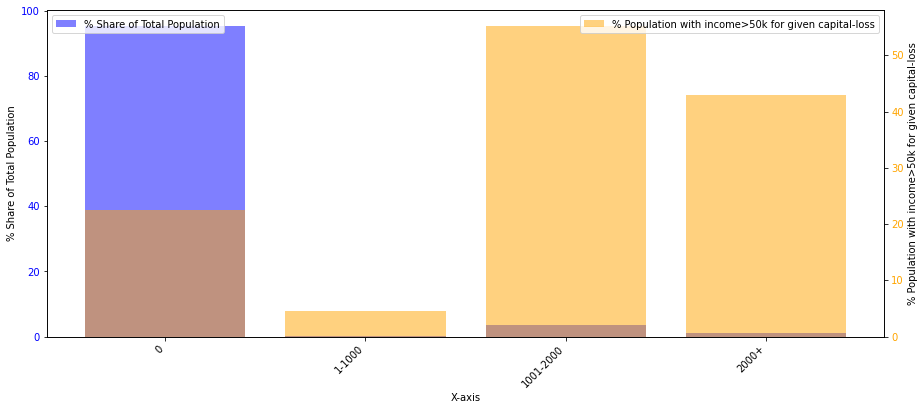

In [52]:
# Create a figure with 2 rows and 1 column
fig, ax1 = plt.subplots(figsize=(15, 6))  # (rows, columns) and set the figure size

# First subplot:
ax1.bar(pivot_df["capital_loss_group"], pivot_df["% Share of Total Population"], color = "blue", label = "% Share of Total Population", alpha = 0.5)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("% Share of Total Population")
ax1.tick_params(axis='y', labelcolor='blue')  # Set color for the left y-axis
ax1.legend(loc="upper left")
ax1.set_xticklabels(list(pivot_df["capital_loss_group"].value_counts().index), rotation=45, ha='right')  # Rotate 45 degrees, aligned to the right


# Second subplot:
ax2 = ax1.twinx()  # Add a second y-axis sharing the same x-axis
ax2.bar(pivot_df["capital_loss_group"], pivot_df["% Population with income>50k for given capital-loss"], color = 'orange', label = "% Population with income>50k for given capital-loss", alpha = 0.5)
ax2.set_ylabel("% Population with income>50k for given capital-loss")
ax2.tick_params(axis='y', labelcolor='orange')  # Set color for the right y-axis
ax2.legend(loc="upper right")

# Display the plot
plt.show()

In [53]:
# Calculate the weighted Chi-square and Cramér's V
chi2, p_value, cramers_v = weighted_chi2_and_cramers_v(df, 'capital_loss_group', 'income', 'fnlwgt')

print("Cramér's V:", cramers_v.round(3))
print("p-value:", p_value.round(3))

Cramér's V: 0.148
p-value: 0.0


## Cramer's V Heatmap

In [54]:
categorical_columns = ['workclass', 'education', 'marital-status',
                       'occupation', 'relationship', 'race', 'sex',
                       'age_group', 'work_hour_group', 'is_us_native',
                       'capital_gain_group', 'capital_loss_group', 'income']
cramers_v_df = cramers_v_matrix(df = df, weight = 'fnlwgt', categorical_columns = categorical_columns)
cramers_v_df

,workclass,education,marital-status,occupation,relationship,race,sex,age_group,work_hour_group,is_us_native,capital_gain_group,capital_loss_group,income
workclass,1.000000,0.098235,0.083131,0.396772,0.098028,0.054752,0.145613,0.120400,0.101150,0.057743,0.075631,0.034760,0.188070
education,0.098235,1.000000,0.093410,0.189791,0.128711,0.078421,0.097074,0.104531,0.071476,0.320476,0.138027,0.063750,0.374547
marital-status,0.083131,0.093410,1.000000,0.132278,0.487097,0.084545,0.453253,0.287481,0.110217,0.125523,0.089655,0.061067,0.452612
occupation,0.396772,0.189791,0.132278,1.000000,0.177195,0.081974,0.415227,0.103415,0.107238,0.132046,0.102562,0.055825,0.357966
relationship,0.098028,0.128711,0.487097,0.177195,1.000000,0.098735,0.639434,0.284735,0.153352,0.133600,0.093224,0.068665,0.458911
race,0.054752,0.078421,0.084545,0.081974,0.098735,1.000000,0.109648,0.036676,0.062232,0.360987,0.021770,0.019040,0.103043
sex,0.145613,0.097074,0.453253,0.415227,0.639434,0.109648,1.000000,0.118831,0.228590,0.021374,0.071457,0.059134,0.211561
age_group,0.120400,0.104531,0.287481,0.103415,0.284735,0.036676,0.118831,1.000000,0.110063,0.057315,0.089957,0.057789,0.331000
work_hour_group,0.101150,0.071476,0.110217,0.107238,0.153352,0.062232,0.228590,0.110063,1.000000,0.060940,0.079602,0.044054,0.272888
is_us_native,0.057743,0.320476,0.125523,0.132046,0.133600,0.360987,0.021374,0.057315,0.060940,1.000000,0.026233,0.010991,0.050003


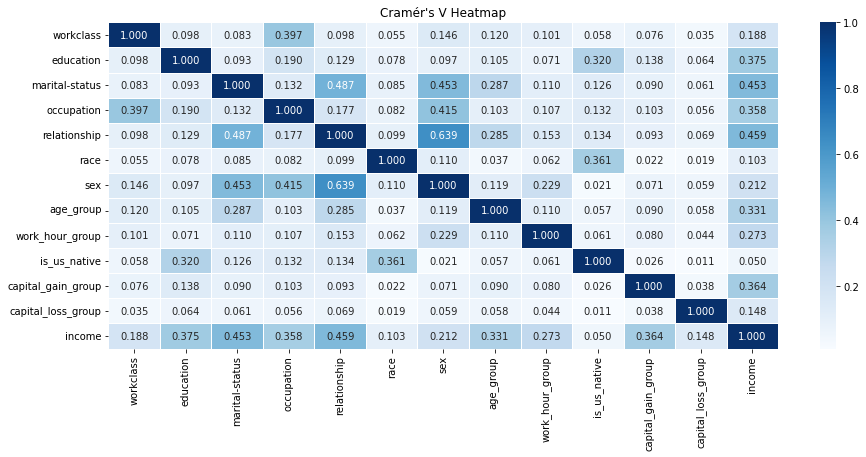

In [55]:
# Plotting a heatmap of Cramér's V values
plt.figure(figsize=(15, 6))
sns.heatmap(cramers_v_df, annot=True, cmap="Blues", fmt=".3f", linewidths=0.5)
plt.title("Cramér's V Heatmap")
plt.show()

- No Feature is showing very high association (>0.9) with other feature

## Modeling

### Data Preprocessing

- Since we have created grouping for `age`, `capital-gain`, `capital-loss`, `hours-per-week`, `native-country` we will drop these.
- We will also drop `income` and keep `income>50k` as the target variable
- Then we will have to do One-Hot Encoding to convert Categorical variables into Numerical

In [56]:
df2 = df.drop(columns = ["age", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"])
categorical_columns = ["workclass", "education", "marital-status", "occupation", "relationship",
                       "race", "sex", "age_group", "work_hour_group", "is_us_native",
                       "capital_gain_group", "capital_loss_group"]
df_encoded = pd.get_dummies(df2, columns = categorical_columns)

In [57]:
# Define Features and Labels
X = df_encoded.drop(columns = ['income>50k', 'fnlwgt'])
y = df_encoded["income>50k"]
weights = df_encoded['fnlwgt']  # Using "Frequency" as sample weights

print(X.shape)
print(y.shape)

(32561, 100)
(32561,)


In [58]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [59]:
# Initialize and fit a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)  # 100 trees in the forest
rf.fit(X_train, y_train, sample_weight=weights[X_train.index])  # Applying sample weights

RandomForestClassifier(class_weight='balanced', random_state=42)

In [60]:
# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy.round(3))
print("Classification Report:")
print(report)

Accuracy: 0.841
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      4945
           1       0.67      0.68      0.67      1568

    accuracy                           0.84      6513
   macro avg       0.78      0.79      0.78      6513
weighted avg       0.84      0.84      0.84      6513



## Predicting income

In [61]:
age = 39
workclass = "State-gov"
education = "Bachelors"
marital_status = "Never-married"
occupation = "Adm-clerical"
relationship = "Not-in-family"
race = "White"
sex = "Male"
capital_gain = 2174
capital_loss = 0
hours_per_week = 40
native_country = "United-States"

- Just change the above parameters and get the probability for Income >50K by running below cells

In [62]:
# Creating the DataFrame for Prediction
pred_df = pd.DataFrame([{"age": age,
                       "workclass": workclass,
                       "education": education,
                       "marital-status": marital_status,
                       "occupation": occupation,
                       "relationship": relationship,
                       "race": race,
                       "sex": sex,
                       "capital-gain": capital_gain,
                       "capital-loss": capital_loss,
                       "hours-per-week": hours_per_week,
                       "native-country": native_country}])

# Grouping columns just like we did for Training Date
pred_df['age_group'] = pd.cut(pred_df['age'], bins=age_bins, labels=age_labels, right=False)
pred_df["capital_loss_group"] = pred_df["capital-loss"].apply(lambda x: "0" if x==0 else
                                                               "1-1000" if x>=1 and x<=1000 else
                                                               "1001-2000" if x>=1001 and x<=2000 else
                                                               "2000+")
pred_df["capital_gain_group"] = pred_df["capital-gain"].apply(lambda x: "0" if x==0 else
                                                               "1-5000" if x>=1 and x<=5000 else
                                                               "5001-10000" if x>=5001 and x<=10000 else
                                                               "10001+")
pred_df["is_us_native"] = pred_df["native-country"].apply(lambda x: "yes" if x=="United-States" else "no")
pred_df['work_hour_group'] = pd.cut(pred_df['hours-per-week'], bins=hours_per_week_bins, labels=hours_per_week_labels, right=False)

# One-Hot Encoding just like for Training Date
pred_df2 = pred_df.drop(columns = ["age", "capital-gain", "capital-loss", "hours-per-week", "native-country"])
categorical_columns = ["workclass", "education", "marital-status", "occupation", "relationship",
                       "race", "sex", "age_group", "work_hour_group", "is_us_native",
                       "capital_gain_group", "capital_loss_group"]
pred_df_encoded = pd.get_dummies(pred_df2, columns = categorical_columns)

# Adding, Removing and Arranging data in Encoded DataFrame for Prediction just like for Training Data
for col in X.columns:
    if col not in pred_df_encoded.columns:
        pred_df_encoded[col] = 0
pred_df_encoded = pred_df_encoded[list(X.columns)]

# Make predictions
predicted_income_proba = rf.predict_proba(pred_df_encoded)
print(f"Probability for Income to be >50K is {predicted_income_proba[0][1].round(3)}")

Probability for Income to be >50K is 0.097
